In [428]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import glob

In [411]:

ds_lr = xr.open_dataset('era5_data_nc/era5_2010_2020_daily.nc', engine='netcdf4')

print(f"Rango de fechas: {ds_lr.coords['time'][0].values} a {ds_lr.coords['time'][-1].values}")
print(f"Número total de muestras: {len(ds_lr.coords['time'])}")



Rango de fechas: 2010-01-01T00:00:00.000000000 a 2020-12-31T00:00:00.000000000
Número total de muestras: 4018


/tmp/ipykernel_9349/4214016695.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds_lr = xr.open_dataset('era5_data_nc/era5_2010_2020_daily.nc', engine='netcdf4')


In [412]:
ds_hr = xr.open_dataset('tmean_cr2met_2010_2020.nc', engine='netcdf4')

print(f"Rango de fechas: {ds_hr.coords['time'][0].values} a {ds_hr.coords['time'][-1].values}")
print(f"Número total de muestras: {len(ds_hr.coords['time'])}")



Rango de fechas: 2010-01-01T00:00:00.000000000 a 2020-12-31T00:00:00.000000000
Número total de muestras: 4018


Recortar HR para que coincida con el rango de latitudes y longitudes de LR

In [414]:
ds_hr_adjusted = ds_hr.sel(
    lat=slice(-33.269, -32.768),
    lon=slice(-71.893, -70.142)
)

Obtener las variables de temperatura en LR y HR


In [415]:
lr_data = ds_lr['t2m'].values 
hr_data = ds_hr_adjusted['tmean'].values

lr_data = lr_data - 273.15  # Kelvin a Celsius

Estandarización de datos

Mínimo valor en X (antes de la estandarización): -22.385269165039062
Máximo valor en X (antes de la estandarización): 26.915802001953125
Mínimo valor en Y (antes de la estandarización): -16.66
Máximo valor en Y (antes de la estandarización): 26.975833333333338


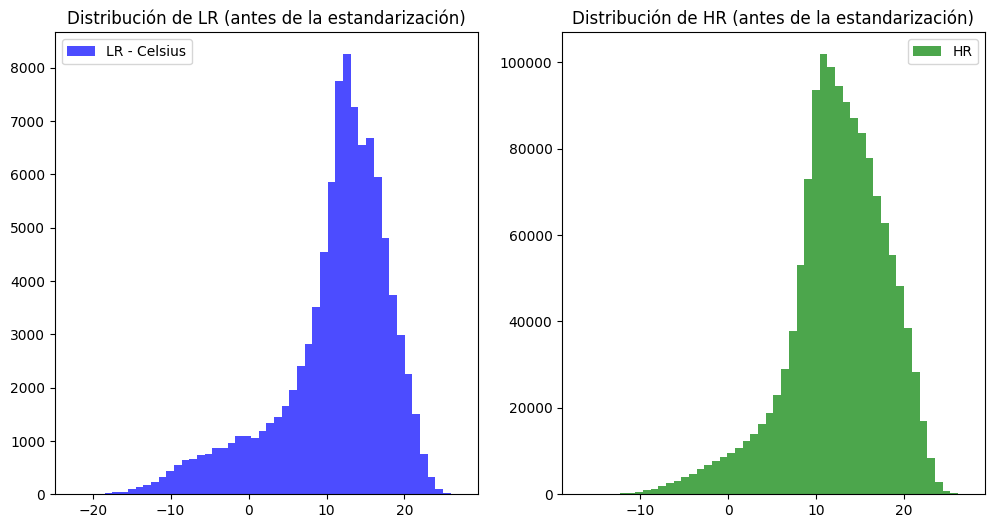

Mínimo valor en X (después de la estandarización): -4.646207809448242
Máximo valor en X (después de la estandarización): 2.208346128463745
Mínimo valor en Y (después de la estandarización): -5.21389595117011
Máximo valor en Y (después de la estandarización): 2.612399732629949


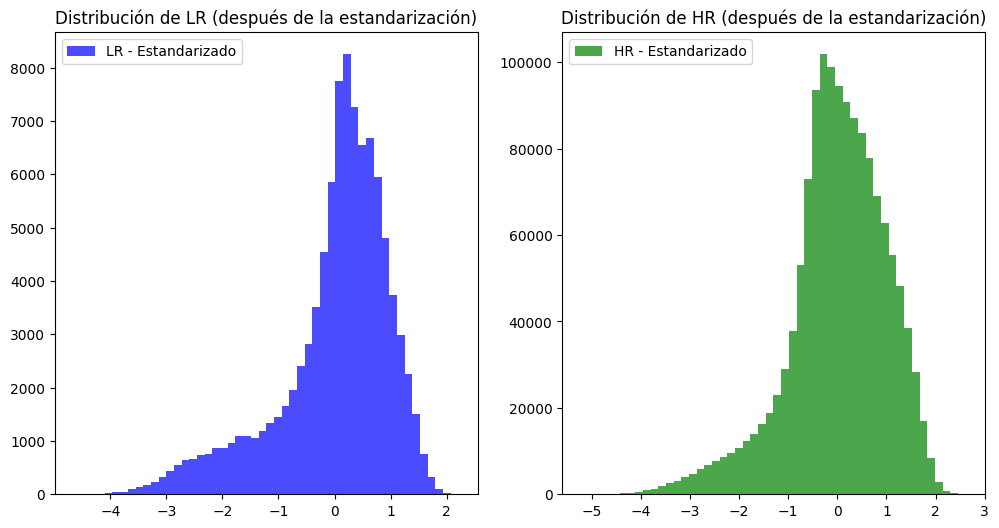

Forma de X (LR) después de la estandarización: (4018, 3, 8, 1)
Forma de Y (HR) después de la estandarización: (4018, 10, 35, 1)


In [ ]:
print(f"Mínimo valor en X (antes de la estandarización): {np.min(lr_data)}")
print(f"Máximo valor en X (antes de la estandarización): {np.max(lr_data)}")
print(f"Mínimo valor en Y (antes de la estandarización): {np.min(hr_data)}")
print(f"Máximo valor en Y (antes de la estandarización): {np.max(hr_data)}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(lr_data.flatten(), bins=50, color='blue', alpha=0.7, label='LR - Celsius')
plt.title('Distribución de LR (antes de la estandarización)')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(hr_data.flatten(), bins=50, color='green', alpha=0.7, label='HR')
plt.title('Distribución de HR (antes de la estandarización)')
plt.legend()
plt.show()

X_mean = np.mean(lr_data)
X_std = np.std(lr_data)
Y_mean = np.mean(hr_data)
Y_std = np.std(hr_data)

X_standardized = (lr_data - X_mean) / X_std
Y_standardized = (hr_data - Y_mean) / Y_std

print(f"Mínimo valor en X (después de la estandarización): {np.min(X_standardized)}")
print(f"Máximo valor en X (después de la estandarización): {np.max(X_standardized)}")
print(f"Mínimo valor en Y (después de la estandarización): {np.min(Y_standardized)}")
print(f"Máximo valor en Y (después de la estandarización): {np.max(Y_standardized)}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(X_standardized.flatten(), bins=50, color='blue', alpha=0.7, label='LR - Estandarizado')
plt.title('Distribución de LR (después de la estandarización)')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(Y_standardized.flatten(), bins=50, color='green', alpha=0.7, label='HR - Estandarizado')
plt.title('Distribución de HR (después de la estandarización)')
plt.legend()
plt.show()

X = X_standardized.reshape(X_standardized.shape[0], X_standardized.shape[1], X_standardized.shape[2], 1)  # LR
Y = Y_standardized.reshape(Y_standardized.shape[0], Y_standardized.shape[1], Y_standardized.shape[2], 1)  # HR

print(f"Forma de X (LR) después de la estandarización: {X.shape}")
print(f"Forma de Y (HR) después de la estandarización: {Y.shape}")

Dividiendo los datos en test y entrenamiento

In [417]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de X_test: {X_test.shape}")
print(f"Forma de y_train: {y_train.shape}")
print(f"Forma de y_test: {y_test.shape}")


Forma de X_train: (3214, 3, 8, 1)
Forma de X_test: (804, 3, 8, 1)
Forma de y_train: (3214, 10, 35, 1)
Forma de y_test: (804, 10, 35, 1)


Definición de funciones

In [418]:
# Función Lambda para imprimir las dimensiones intermedias
def print_shape(x):
    print(f"Shape de la capa {x.name}: {x.shape}") 
    return x


In [430]:
# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    test_loss = model.evaluate(X_test, y_test)
    print(f"Test loss: {test_loss}")
    return test_loss


In [431]:
# Function to plot training and validation loss
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')

    plt.title('Loss during Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [432]:
# Function to show examples and calculate the loss for each prediction
def show_examples(model, X_test, y_test):
    loss_function = tf.keras.losses.MeanSquaredError()

    y_pred = model.predict(X_test)

    plt.figure(figsize=(15, 10))

    for i in range(5):
        plt.subplot(3, 5, i+1)
        plt.imshow(X_test[i, :, :, 0], cmap='viridis')  # LR images
        plt.title(f"LR: {i+1}")
        plt.axis('off')

        plt.subplot(3, 5, i+6)
        plt.imshow(y_test[i, :, :, 0], cmap='viridis')  # Ground truth (HR) images
        plt.title(f"Real: {i+1}")
        plt.axis('off')

        plt.subplot(3, 5, i+11)
        plt.imshow(y_pred[i, :, :, 0], cmap='viridis')  # Predictions
        plt.title(f"Prediction: {i+1}")
        plt.axis('off')

        loss_value = loss_function(y_test[i:i+1], y_pred[i:i+1]).numpy()

        plt.text(1, 2, f'Loss: {loss_value:.4f}', color='white', fontsize=12)

    plt.tight_layout()
    plt.show()


Importaciones necesarias de tensorflow para hacer el modelo

In [436]:
from tensorflow.keras import layers, models, regularizers # type: ignore
from tensorflow.keras.callbacks import ReduceLROnPlateau # type: ignore
from tensorflow.keras.optimizers import Adam, RMSprop, SGD # type: ignore


In [ ]:
model_1 = models.Sequential([
    layers.InputLayer(shape=(X_train.shape[1], X_train.shape[2], 1), name='Input_Layer'),
    
    # Capa convolucional con normalización por lotes
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='Conv2D_1'),
    layers.BatchNormalization(),  # Normalización de lotes


    # Aumento de resolución usando Conv2DTranspose (de 3x8 a 6x16)
    layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', name='Conv2DTranspose_1'),


    # Aumento de resolución usando Conv2DTranspose (de 6x16 a 12x32)
    layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', name='Conv2DTranspose_2'),


    # Capa de Dropout para evitar sobreajuste
    layers.Dropout(0.3),

    # Reducción de resolución para ajustar las dimensiones (de 12x32 a 12x32)
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='Conv2D_2'),


    # Otra capa de convolución para aprender más características (de 12x32 a 12x32)
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='Conv2D_3'),


    # Aumento de resolución usando UpSampling2D y Conv2D para refinar la resolución
    layers.UpSampling2D(size=(2, 3), interpolation='bilinear', name="UpSampling_Layer"),  # Ajuste de resolución
  # Imprime las dimensiones después de la capa de aumento de resolución

    # Capa final para generar la salida de alta resolución (HR)
    layers.Conv2D(1, (3, 3), activation='linear', padding='same', name='Conv2D_4'),


    # Cropping2D para recortar las dimensiones a 10x35
    layers.Cropping2D(cropping=((7, 7), (30, 31)), name="Cropping_Layer"),

])

Shape de la capa Placeholder:0: (None, 3, 8, 64)
Shape de la capa Placeholder:0: (None, 6, 16, 128)
Shape de la capa Placeholder:0: (None, 12, 32, 256)
Shape de la capa Placeholder:0: (None, 12, 32, 128)
Shape de la capa Placeholder:0: (None, 12, 32, 128)
Shape de la capa Placeholder:0: (None, 24, 96, 128)
Shape de la capa Placeholder:0: (None, 24, 96, 1)
Shape de la capa Placeholder:0: (None, 10, 35, 1)


In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [433]:
model_1.compile(optimizer=SGD(learning_rate=1e-6, momentum=0.9), loss='mean_squared_error')
model_1.summary()
history_1 = model_1.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                    callbacks=[reduce_lr, early_stopping])

Model: "sequential_129"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv2D_1 (Conv2D)               │ (None, 3, 8, 64)       │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_82          │ (None, 3, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_831 (Lambda)             │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2DTranspose_1               │ (None, 6, 16, 128)     │        73,856 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_832 (Lambda)             │ (None, 6, 16, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2DTranspose_2               │ (None, 12, 32, 256)    │       295,168 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_833 (Lambda)             │ (None, 12, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_82 (Dropout)            │ (None, 12, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_2 (Conv2D)               │ (None, 12, 32, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_834 (Lambda)             │ (None, 12, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_3 (Conv2D)               │ (None, 12, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_835 (Lambda)             │ (None, 12, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ UpSampling_Layer (UpSampling2D) │ (None, 24, 96, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_836 (Lambda)             │ (None, 24, 96, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_4 (Conv2D)               │ (None, 24, 96, 1)      │         1,153 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_837 (Lambda)             │ (None, 24, 96, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Cropping_Layer (Cropping2D)     │ (None, 10, 35, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_838 (Lambda)             │ (None, 10, 35, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 813,697 (3.10 MB)

 Trainable params: 813,569 (3.10 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/50
Shape de la capa sequential_129_1/batch_normalization_82_1/batchnorm/add_1:0: (None, 3, 8, 64)
Shape de la capa sequential_129_1/Conv2DTranspose_1_1/BiasAdd:0: (None, 6, 16, 128)
Shape de la capa sequential_129_1/Conv2DTranspose_2_1/BiasAdd:0: (None, 12, 32, 256)
Shape de la capa sequential_129_1/Conv2D_2_1/Relu:0: (None, 12, 32, 128)
Shape de la capa sequential_129_1/Conv2D_3_1/Relu:0: (None, 12, 32, 128)
Shape de la capa sequential_129_1/UpSampling_Layer_1/resize/ResizeBilinear:0: (None, 24, 96, 128)
Shape de la capa sequential_129_1/Conv2D_4_1/Add:0: (None, 24, 96, 1)
Shape de la capa sequential_129_1/Cropping_Layer_1/strided_slice:0: (None, 10, 35, 1)
Shape de la capa sequential_129_1/batch_normalization_82_1/batchnorm/add_1:0: (None, 3, 8, 64)
Shape de la capa sequential_129_1/Conv2DTranspose_1_1/BiasAdd:0: (None, 6, 16, 128)
Shape de la capa sequential_129_1/Conv2DTranspose_2_1/BiasAdd:0: (None, 12, 32, 256)
Shape de la capa sequential_129_1/Conv2D_2_1/Relu:0: (None, 1

2025-03-26 11:10:57.536845: W external/local_xla/xla/service/gpu/transforms/conv_rewriter.cc:467] The low padding of the backward convolution would be negative (-6), which isn't supported by GpuConvPaddingLegalization for now (b/32744257).


 97/101 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.3833

2025-03-26 11:10:59.303397: W external/local_xla/xla/service/gpu/transforms/conv_rewriter.cc:467] The low padding of the backward convolution would be negative (-6), which isn't supported by GpuConvPaddingLegalization for now (b/32744257).


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 6.3794Shape de la capa sequential_129_1/batch_normalization_82_1/batchnorm/add_1:0: (None, 3, 8, 64)
Shape de la capa sequential_129_1/Conv2DTranspose_1_1/BiasAdd:0: (None, 6, 16, 128)
Shape de la capa sequential_129_1/Conv2DTranspose_2_1/BiasAdd:0: (None, 12, 32, 256)
Shape de la capa sequential_129_1/Conv2D_2_1/Relu:0: (None, 12, 32, 128)
Shape de la capa sequential_129_1/Conv2D_3_1/Relu:0: (None, 12, 32, 128)
Shape de la capa sequential_129_1/UpSampling_Layer_1/resize/ResizeBilinear:0: (None, 24, 96, 128)
Shape de la capa sequential_129_1/Conv2D_4_1/Add:0: (None, 24, 96, 1)
Shape de la capa sequential_129_1/Cropping_Layer_1/strided_slice:0: (None, 10, 35, 1)
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 6.3784 - val_loss: 5.8367 - learning_rate: 1.0000e-06
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.0430 - val_loss: 5.8710 - learning_rate: 1.0000e-06
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0084
Test loss: 3.9083192348480225


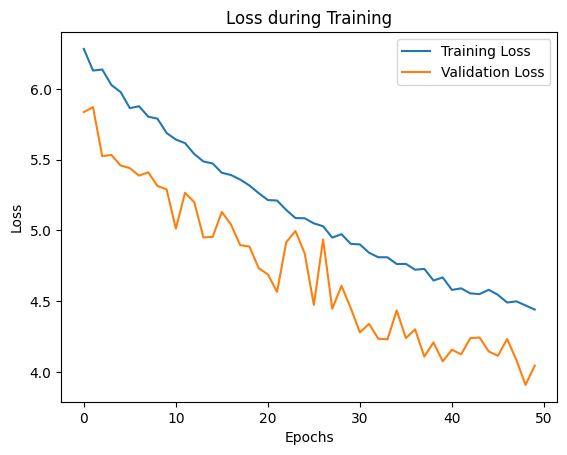

Shape de la capa sequential_129_1/batch_normalization_82_1/batchnorm/add_1:0: (32, 3, 8, 64)
Shape de la capa sequential_129_1/Conv2DTranspose_1_1/BiasAdd:0: (32, 6, 16, 128)
Shape de la capa sequential_129_1/Conv2DTranspose_2_1/BiasAdd:0: (32, 12, 32, 256)
Shape de la capa sequential_129_1/Conv2D_2_1/Relu:0: (32, 12, 32, 128)
Shape de la capa sequential_129_1/Conv2D_3_1/Relu:0: (32, 12, 32, 128)
Shape de la capa sequential_129_1/UpSampling_Layer_1/resize/ResizeBilinear:0: (32, 24, 96, 128)
Shape de la capa sequential_129_1/Conv2D_4_1/Add:0: (32, 24, 96, 1)
Shape de la capa sequential_129_1/Cropping_Layer_1/strided_slice:0: (32, 10, 35, 1)
19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  Shape de la capa sequential_129_1/batch_normalization_82_1/batchnorm/add_1:0: (None, 3, 8, 64)
Shape de la capa sequential_129_1/Conv2DTranspose_1_1/BiasAdd:0: (None, 6, 16, 128)
Shape de la capa sequential_129_1/Conv2DTranspose_2_1/BiasAdd:0: (None, 12, 32, 256)
Shape de la capa sequential_129_1/Conv2D_2_1/Rel

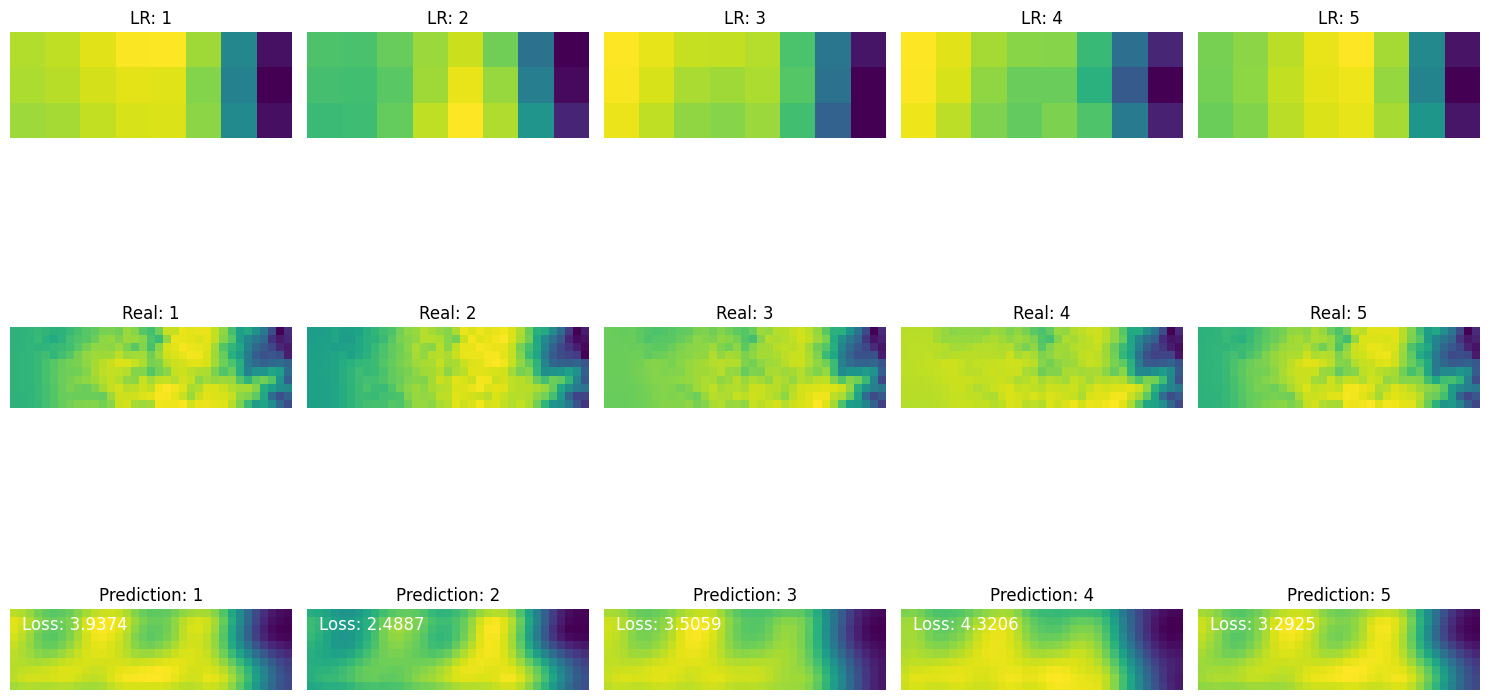

In [434]:
evaluate_model(model_1, X_test, y_test)
plot_loss(history_1)
show_examples(model_1, X_test, y_test)

Siguiente modelo con RSMprop y Regularización L2

In [ ]:
# Reconstrucción del modelo con regularización L2 y optimizador RMSprop
model_2 = models.Sequential([
    layers.InputLayer(shape=(X_train.shape[1], X_train.shape[2], 1), name='Input_Layer'),
    
    # Capa convolucional con normalización por lotes y regularización L2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                  kernel_regularizer=regularizers.l2(0.01), name='Conv2D_1'),
    layers.BatchNormalization(),  # Normalización de lotes


    # Aumento de resolución usando Conv2DTranspose (de 3x8 a 6x16)
    layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', name='Conv2DTranspose_1'),


    # Aumento de resolución usando Conv2DTranspose (de 6x16 a 12x32)
    layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', name='Conv2DTranspose_2'),


    # Capa de Dropout para evitar sobreajuste
    layers.Dropout(0.5),

    # Reducción de resolución para ajustar las dimensiones
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='Conv2D_2'),


    # Otra capa de convolución para aprender más características
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='Conv2D_3'),


    # Aumento de resolución usando UpSampling2D y Conv2D para refinar la resolución
    layers.UpSampling2D(size=(2, 3), interpolation='bilinear', name="UpSampling_Layer"),  # Ajuste de resolución
  # Imprime las dimensiones después de la capa de aumento de resolución

    # Capa final para generar la salida de alta resolución (HR)
    layers.Conv2D(1, (3, 3), activation='linear', padding='same', name='Conv2D_4'),


    # Cropping2D para recortar las dimensiones a 10x35
    layers.Cropping2D(cropping=((7, 7), (30, 31)), name="Cropping_Layer"),

])

Shape de la capa Placeholder:0: (None, 3, 8, 64)
Shape de la capa Placeholder:0: (None, 6, 16, 128)
Shape de la capa Placeholder:0: (None, 12, 32, 256)
Shape de la capa Placeholder:0: (None, 12, 32, 128)
Shape de la capa Placeholder:0: (None, 12, 32, 128)
Shape de la capa Placeholder:0: (None, 24, 96, 128)
Shape de la capa Placeholder:0: (None, 24, 96, 1)
Shape de la capa Placeholder:0: (None, 10, 35, 1)


In [439]:
optimizer = RMSprop(learning_rate=1e-4)
model_2.compile(optimizer=optimizer, loss='mean_squared_error')
model_2.summary()
history_2 = model_2.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                    callbacks=[reduce_lr, early_stopping])

Model: "sequential_132"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv2D_1 (Conv2D)               │ (None, 3, 8, 64)       │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_85          │ (None, 3, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_855 (Lambda)             │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2DTranspose_1               │ (None, 6, 16, 128)     │        73,856 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_856 (Lambda)             │ (None, 6, 16, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2DTranspose_2               │ (None, 12, 32, 256)    │       295,168 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_857 (Lambda)             │ (None, 12, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_85 (Dropout)            │ (None, 12, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_2 (Conv2D)               │ (None, 12, 32, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_858 (Lambda)             │ (None, 12, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_3 (Conv2D)               │ (None, 12, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_859 (Lambda)             │ (None, 12, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ UpSampling_Layer (UpSampling2D) │ (None, 24, 96, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_860 (Lambda)             │ (None, 24, 96, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_4 (Conv2D)               │ (None, 24, 96, 1)      │         1,153 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_861 (Lambda)             │ (None, 24, 96, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Cropping_Layer (Cropping2D)     │ (None, 10, 35, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_862 (Lambda)             │ (None, 10, 35, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 813,697 (3.10 MB)

 Trainable params: 813,569 (3.10 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/50
Shape de la capa sequential_132_1/batch_normalization_85_1/batchnorm/add_1:0: (None, 3, 8, 64)
Shape de la capa sequential_132_1/Conv2DTranspose_1_1/BiasAdd:0: (None, 6, 16, 128)
Shape de la capa sequential_132_1/Conv2DTranspose_2_1/BiasAdd:0: (None, 12, 32, 256)
Shape de la capa sequential_132_1/Conv2D_2_1/Relu:0: (None, 12, 32, 128)
Shape de la capa sequential_132_1/Conv2D_3_1/Relu:0: (None, 12, 32, 128)
Shape de la capa sequential_132_1/UpSampling_Layer_1/resize/ResizeBilinear:0: (None, 24, 96, 128)
Shape de la capa sequential_132_1/Conv2D_4_1/Add:0: (None, 24, 96, 1)
Shape de la capa sequential_132_1/Cropping_Layer_1/strided_slice:0: (None, 10, 35, 1)
Shape de la capa sequential_132_1/batch_normalization_85_1/batchnorm/add_1:0: (None, 3, 8, 64)
Shape de la capa sequential_132_1/Conv2DTranspose_1_1/BiasAdd:0: (None, 6, 16, 128)
Shape de la capa sequential_132_1/Conv2DTranspose_2_1/BiasAdd:0: (None, 12, 32, 256)
Shape de la capa sequential_132_1/Conv2D_2_1/Relu:0: (None, 1

2025-03-26 11:15:25.513929: W external/local_xla/xla/service/gpu/transforms/conv_rewriter.cc:467] The low padding of the backward convolution would be negative (-6), which isn't supported by GpuConvPaddingLegalization for now (b/32744257).


 94/101 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 49.2093

2025-03-26 11:15:27.296004: W external/local_xla/xla/service/gpu/transforms/conv_rewriter.cc:467] The low padding of the backward convolution would be negative (-6), which isn't supported by GpuConvPaddingLegalization for now (b/32744257).


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 47.1973Shape de la capa sequential_132_1/batch_normalization_85_1/batchnorm/add_1:0: (None, 3, 8, 64)
Shape de la capa sequential_132_1/Conv2DTranspose_1_1/BiasAdd:0: (None, 6, 16, 128)
Shape de la capa sequential_132_1/Conv2DTranspose_2_1/BiasAdd:0: (None, 12, 32, 256)
Shape de la capa sequential_132_1/Conv2D_2_1/Relu:0: (None, 12, 32, 128)
Shape de la capa sequential_132_1/Conv2D_3_1/Relu:0: (None, 12, 32, 128)
Shape de la capa sequential_132_1/UpSampling_Layer_1/resize/ResizeBilinear:0: (None, 24, 96, 128)
Shape de la capa sequential_132_1/Conv2D_4_1/Add:0: (None, 24, 96, 1)
Shape de la capa sequential_132_1/Cropping_Layer_1/strided_slice:0: (None, 10, 35, 1)
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 46.9292 - val_loss: 20.4164 - learning_rate: 1.0000e-04
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.4836 - val_loss: 4.0471 - learning_rate: 1.0000e-04
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss:

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2124
Test loss: 1.1896693706512451


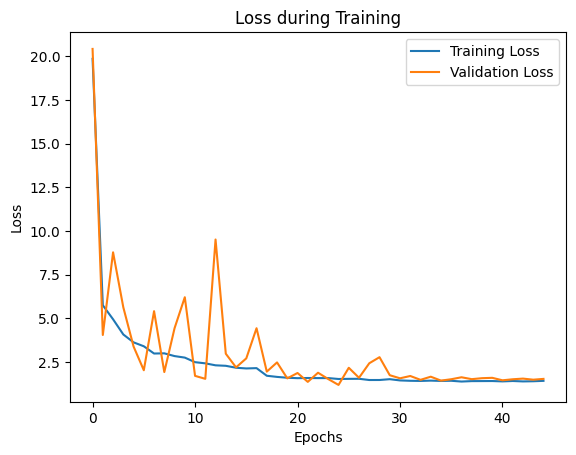

Shape de la capa sequential_132_1/batch_normalization_85_1/batchnorm/add_1:0: (32, 3, 8, 64)
Shape de la capa sequential_132_1/Conv2DTranspose_1_1/BiasAdd:0: (32, 6, 16, 128)
Shape de la capa sequential_132_1/Conv2DTranspose_2_1/BiasAdd:0: (32, 12, 32, 256)
Shape de la capa sequential_132_1/Conv2D_2_1/Relu:0: (32, 12, 32, 128)
Shape de la capa sequential_132_1/Conv2D_3_1/Relu:0: (32, 12, 32, 128)
Shape de la capa sequential_132_1/UpSampling_Layer_1/resize/ResizeBilinear:0: (32, 24, 96, 128)
Shape de la capa sequential_132_1/Conv2D_4_1/Add:0: (32, 24, 96, 1)
Shape de la capa sequential_132_1/Cropping_Layer_1/strided_slice:0: (32, 10, 35, 1)
20/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  Shape de la capa sequential_132_1/batch_normalization_85_1/batchnorm/add_1:0: (None, 3, 8, 64)
Shape de la capa sequential_132_1/Conv2DTranspose_1_1/BiasAdd:0: (None, 6, 16, 128)
Shape de la capa sequential_132_1/Conv2DTranspose_2_1/BiasAdd:0: (None, 12, 32, 256)
Shape de la capa sequential_132_1/Conv2D_2_1/Rel

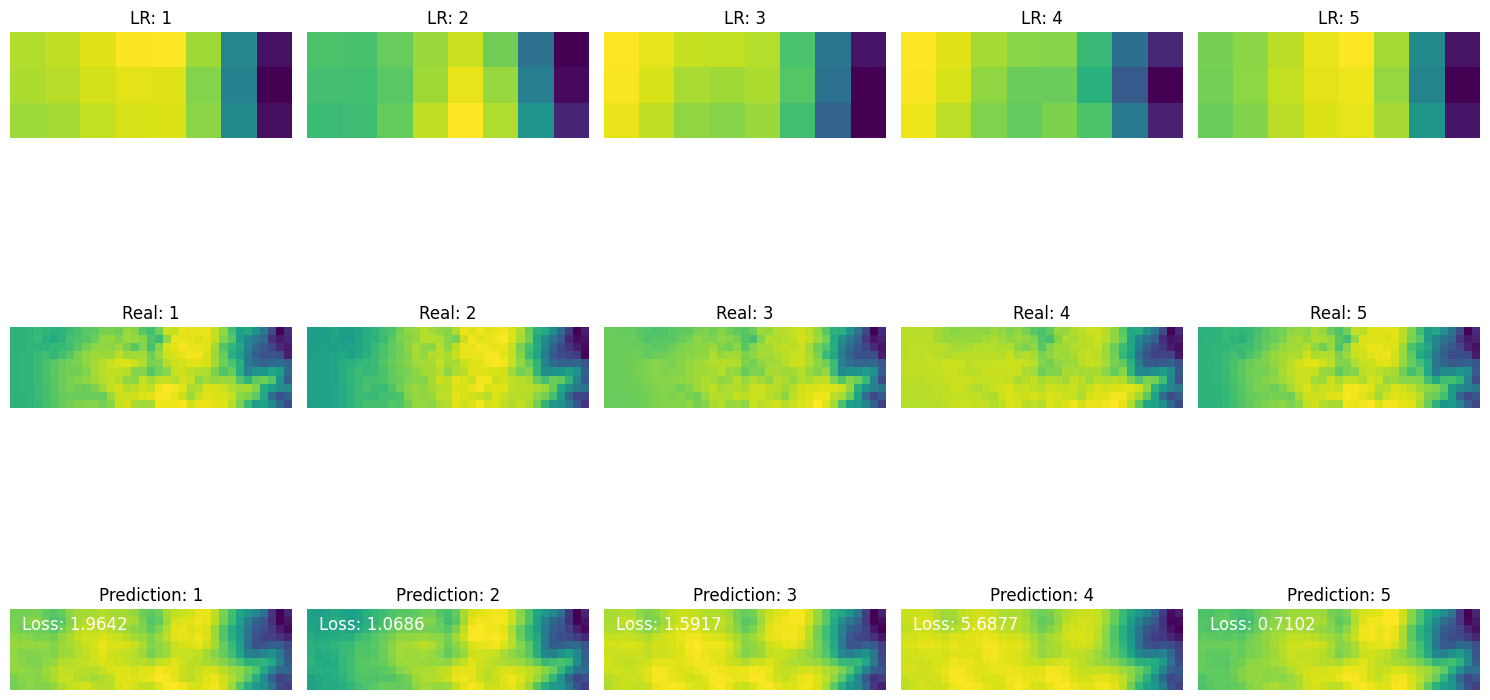

In [440]:
evaluate_model(model_2, X_test, y_test)
plot_loss(history_2)
show_examples(model_2, X_test, y_test)

Modelo con UpSampling2D ajustado

In [ ]:
# Reconstrucción del modelo con UpSampling2D ajustado
model_3 = models.Sequential([
    layers.InputLayer(shape=(X_train.shape[1], X_train.shape[2], 1), name='Input_Layer'),
    
    # Capa convolucional con normalización por lotes
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='Conv2D_1'),
    layers.BatchNormalization(),  # Normalización de lotes


    # Aumento de resolución usando Conv2DTranspose (de 3x8 a 6x16)
    layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', name='Conv2DTranspose_1'),


    # Aumento de resolución usando Conv2DTranspose (de 6x16 a 12x32)
    layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', name='Conv2DTranspose_2'),


    # Capa de Dropout para evitar sobreajuste
    layers.Dropout(0.5),

    # Reducción de resolución para ajustar las dimensiones
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='Conv2D_2'),


    # Otra capa de convolución para aprender más características
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='Conv2D_3'),


    # Aumento de resolución usando UpSampling2D con escala (2, 2)
    layers.UpSampling2D(size=(2, 2), interpolation='bilinear', name="UpSampling_Layer"),  # Ajuste de resolución uniforme
  # Imprime las dimensiones después de la capa de aumento de resolución

    # Capa final para generar la salida de alta resolución (HR)
    layers.Conv2D(1, (3, 3), activation='linear', padding='same', name='Conv2D_4'),


    # Cropping2D para recortar las dimensiones a 10x35
    layers.Cropping2D(cropping=((7, 7), (25, 4)), name="Cropping_Layer"),

])


Shape de la capa Placeholder:0: (None, 3, 8, 64)
Shape de la capa Placeholder:0: (None, 6, 16, 128)
Shape de la capa Placeholder:0: (None, 12, 32, 256)
Shape de la capa Placeholder:0: (None, 12, 32, 128)
Shape de la capa Placeholder:0: (None, 12, 32, 128)
Shape de la capa Placeholder:0: (None, 24, 64, 128)
Shape de la capa Placeholder:0: (None, 24, 64, 1)
Shape de la capa Placeholder:0: (None, 10, 35, 1)


In [442]:
model_3.compile(optimizer='adam', loss='mean_squared_error')
model_3.summary()
history_3 = model_3.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                    callbacks=[reduce_lr, early_stopping])

Model: "sequential_133"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv2D_1 (Conv2D)               │ (None, 3, 8, 64)       │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_86          │ (None, 3, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_863 (Lambda)             │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2DTranspose_1               │ (None, 6, 16, 128)     │        73,856 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_864 (Lambda)             │ (None, 6, 16, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2DTranspose_2               │ (None, 12, 32, 256)    │       295,168 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_865 (Lambda)             │ (None, 12, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_86 (Dropout)            │ (None, 12, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_2 (Conv2D)               │ (None, 12, 32, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_866 (Lambda)             │ (None, 12, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_3 (Conv2D)               │ (None, 12, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_867 (Lambda)             │ (None, 12, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ UpSampling_Layer (UpSampling2D) │ (None, 24, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_868 (Lambda)             │ (None, 24, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_4 (Conv2D)               │ (None, 24, 64, 1)      │         1,153 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_869 (Lambda)             │ (None, 24, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Cropping_Layer (Cropping2D)     │ (None, 10, 35, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_870 (Lambda)             │ (None, 10, 35, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 813,697 (3.10 MB)

 Trainable params: 813,569 (3.10 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/50
Shape de la capa sequential_133_1/batch_normalization_86_1/batchnorm/add_1:0: (None, 3, 8, 64)
Shape de la capa sequential_133_1/Conv2DTranspose_1_1/BiasAdd:0: (None, 6, 16, 128)
Shape de la capa sequential_133_1/Conv2DTranspose_2_1/BiasAdd:0: (None, 12, 32, 256)
Shape de la capa sequential_133_1/Conv2D_2_1/Relu:0: (None, 12, 32, 128)
Shape de la capa sequential_133_1/Conv2D_3_1/Relu:0: (None, 12, 32, 128)
Shape de la capa sequential_133_1/UpSampling_Layer_1/resize/ResizeBilinear:0: (None, 24, 64, 128)
Shape de la capa sequential_133_1/Conv2D_4_1/Add:0: (None, 24, 64, 1)
Shape de la capa sequential_133_1/Cropping_Layer_1/strided_slice:0: (None, 10, 35, 1)
Shape de la capa sequential_133_1/batch_normalization_86_1/batchnorm/add_1:0: (None, 3, 8, 64)
Shape de la capa sequential_133_1/Conv2DTranspose_1_1/BiasAdd:0: (None, 6, 16, 128)
Shape de la capa sequential_133_1/Conv2DTranspose_2_1/BiasAdd:0: (None, 12, 32, 256)
Shape de la capa sequential_133_1/Conv2D_2_1/Relu:0: (None, 1

2025-03-26 11:17:40.866209: W external/local_xla/xla/service/gpu/transforms/conv_rewriter.cc:467] The low padding of the backward convolution would be negative (-6), which isn't supported by GpuConvPaddingLegalization for now (b/32744257).


 94/101 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 26.7814

2025-03-26 11:17:42.568816: W external/local_xla/xla/service/gpu/transforms/conv_rewriter.cc:467] The low padding of the backward convolution would be negative (-6), which isn't supported by GpuConvPaddingLegalization for now (b/32744257).


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 25.5680Shape de la capa sequential_133_1/batch_normalization_86_1/batchnorm/add_1:0: (None, 3, 8, 64)
Shape de la capa sequential_133_1/Conv2DTranspose_1_1/BiasAdd:0: (None, 6, 16, 128)
Shape de la capa sequential_133_1/Conv2DTranspose_2_1/BiasAdd:0: (None, 12, 32, 256)
Shape de la capa sequential_133_1/Conv2D_2_1/Relu:0: (None, 12, 32, 128)
Shape de la capa sequential_133_1/Conv2D_3_1/Relu:0: (None, 12, 32, 128)
Shape de la capa sequential_133_1/UpSampling_Layer_1/resize/ResizeBilinear:0: (None, 24, 64, 128)
Shape de la capa sequential_133_1/Conv2D_4_1/Add:0: (None, 24, 64, 1)
Shape de la capa sequential_133_1/Cropping_Layer_1/strided_slice:0: (None, 10, 35, 1)
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 25.4065 - val_loss: 17.1668 - learning_rate: 0.0010
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.8397 - val_loss: 7.4392 - learning_rate: 0.0010
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.5933 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1200
Test loss: 1.1031684875488281


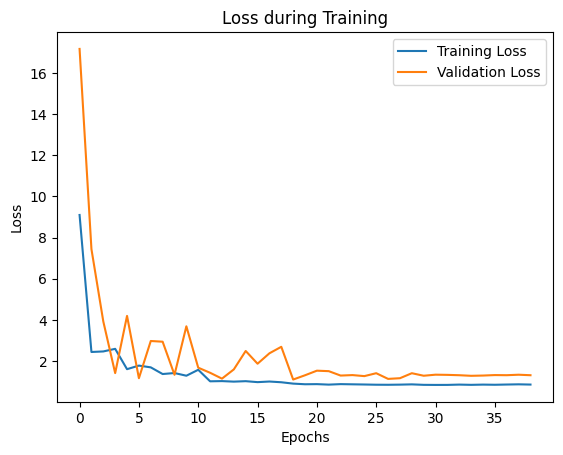

Shape de la capa sequential_133_1/batch_normalization_86_1/batchnorm/add_1:0: (32, 3, 8, 64)
Shape de la capa sequential_133_1/Conv2DTranspose_1_1/BiasAdd:0: (32, 6, 16, 128)
Shape de la capa sequential_133_1/Conv2DTranspose_2_1/BiasAdd:0: (32, 12, 32, 256)
Shape de la capa sequential_133_1/Conv2D_2_1/Relu:0: (32, 12, 32, 128)
Shape de la capa sequential_133_1/Conv2D_3_1/Relu:0: (32, 12, 32, 128)
Shape de la capa sequential_133_1/UpSampling_Layer_1/resize/ResizeBilinear:0: (32, 24, 64, 128)
Shape de la capa sequential_133_1/Conv2D_4_1/Add:0: (32, 24, 64, 1)
Shape de la capa sequential_133_1/Cropping_Layer_1/strided_slice:0: (32, 10, 35, 1)
23/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  Shape de la capa sequential_133_1/batch_normalization_86_1/batchnorm/add_1:0: (None, 3, 8, 64)
Shape de la capa sequential_133_1/Conv2DTranspose_1_1/BiasAdd:0: (None, 6, 16, 128)
Shape de la capa sequential_133_1/Conv2DTranspose_2_1/BiasAdd:0: (None, 12, 32, 256)
Shape de la capa sequential_133_1/Conv2D_2_1/Rel

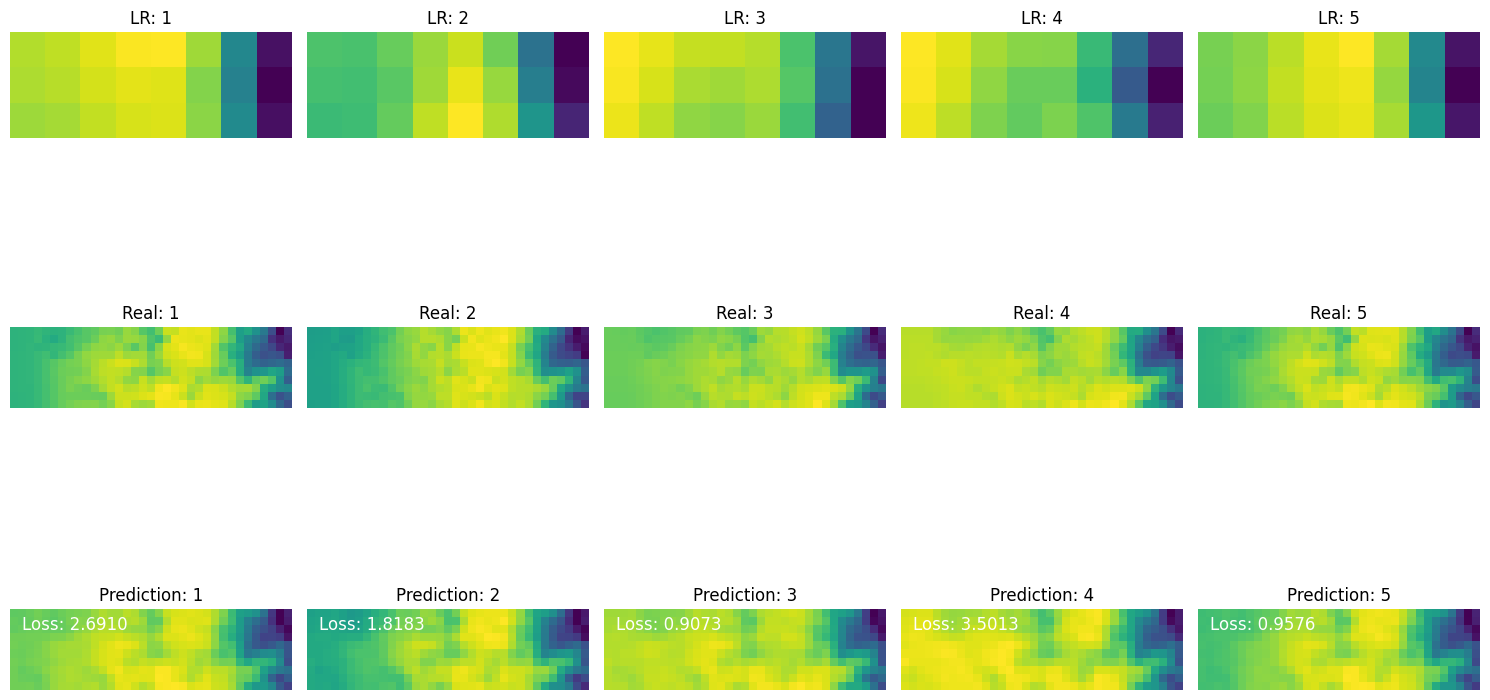

In [443]:
evaluate_model(model_3, X_test, y_test)
plot_loss(history_3)
show_examples(model_3, X_test, y_test)

Reconstrucción del modelo con regularización L2


In [466]:
model_4 = models.Sequential([
    layers.InputLayer(shape=(X_train.shape[1], X_train.shape[2], 1), name='Input_Layer'),
    
    # Capa convolucional con normalización por lotes y regularización L2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                  kernel_regularizer=regularizers.l2(0.01), name='Conv2D_1'),  # L2 regularization
    layers.BatchNormalization(),  # Normalización de lotes


    # Aumento de resolución usando Conv2DTranspose (de 3x8 a 6x16)
    layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', 
                           kernel_regularizer=regularizers.l2(0.01), name='Conv2DTranspose_1'),


    # Aumento de resolución usando Conv2DTranspose (de 6x16 a 12x32)
    layers.Conv2DTranspose(256, (3, 3), strides=(2, 3), padding='same', 
                           kernel_regularizer=regularizers.l2(0.01), name='Conv2DTranspose_2'),


    # Capa de Dropout para evitar sobreajuste
    layers.Dropout(0.3),

    # Reducción de resolución para ajustar las dimensiones
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                  kernel_regularizer=regularizers.l2(0.01), name='Conv2D_2'),


    # Otra capa de convolución para aprender más características
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                  kernel_regularizer=regularizers.l2(0.01), name='Conv2D_3'),


    # Capa final para generar la salida de alta resolución (HR)
    layers.Conv2D(1, (3, 3), activation='linear', padding='same', name='Conv2D_4'),


    # Cropping2D para recortar las dimensiones a 10x35
    layers.Cropping2D(cropping=((1, 1), (6, 7)), name="Cropping_Layer"),

])


In [467]:
model_4.compile(optimizer='adam', loss='mean_squared_error')
model_4.summary()
history_4 = model_4.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                    callbacks=[reduce_lr, early_stopping])

Model: "sequential_137"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv2D_1 (Conv2D)               │ (None, 3, 8, 64)       │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_90          │ (None, 3, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2DTranspose_1               │ (None, 6, 16, 128)     │        73,856 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2DTranspose_2               │ (None, 12, 48, 256)    │       295,168 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_90 (Dropout)            │ (None, 12, 48, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_2 (Conv2D)               │ (None, 12, 48, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_3 (Conv2D)               │ (None, 12, 48, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_4 (Conv2D)               │ (None, 12, 48, 1)      │         1,153 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Cropping_Layer (Cropping2D)     │ (None, 10, 35, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 813,697 (3.10 MB)

 Trainable params: 813,569 (3.10 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/50


2025-03-26 11:41:16.548715: W external/local_xla/xla/service/gpu/transforms/conv_rewriter.cc:467] The low padding of the backward convolution would be negative (-5), which isn't supported by GpuConvPaddingLegalization for now (b/32744257).


 99/101 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 40.7651

2025-03-26 11:41:18.116673: W external/local_xla/xla/service/gpu/transforms/conv_rewriter.cc:467] The low padding of the backward convolution would be negative (-5), which isn't supported by GpuConvPaddingLegalization for now (b/32744257).


101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 40.0988 - val_loss: 17.2391 - learning_rate: 0.0010
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.7380 - val_loss: 7.4758 - learning_rate: 0.0010
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.0350 - val_loss: 9.5760 - learning_rate: 0.0010
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.1429 - val_loss: 7.6424 - learning_rate: 0.0010
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.7824 - val_loss: 4.7299 - learning_rate: 0.0010
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.6112 - val_loss: 4.3115 - learning_rate: 0.0010
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.7801 - val_loss: 6.9669 - learning_rate: 0.0010
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.7710 - val_loss: 3.5583 - learning_rate: 0.0010
Epoch 9/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.8351 - val_loss: 3.4393 - learning_rate: 0.0010
Epoch 10/50
101/10

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4488 
Test loss: 1.4329088926315308


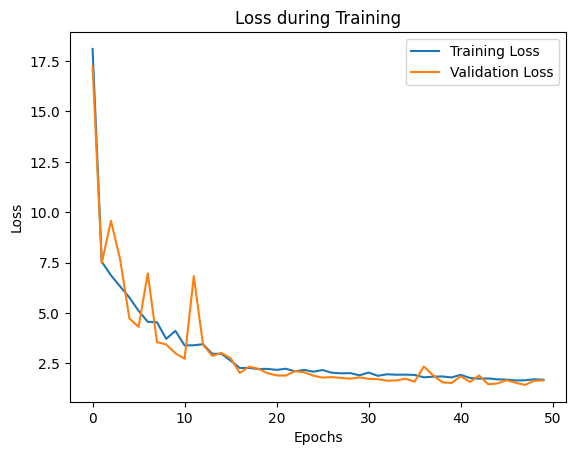

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


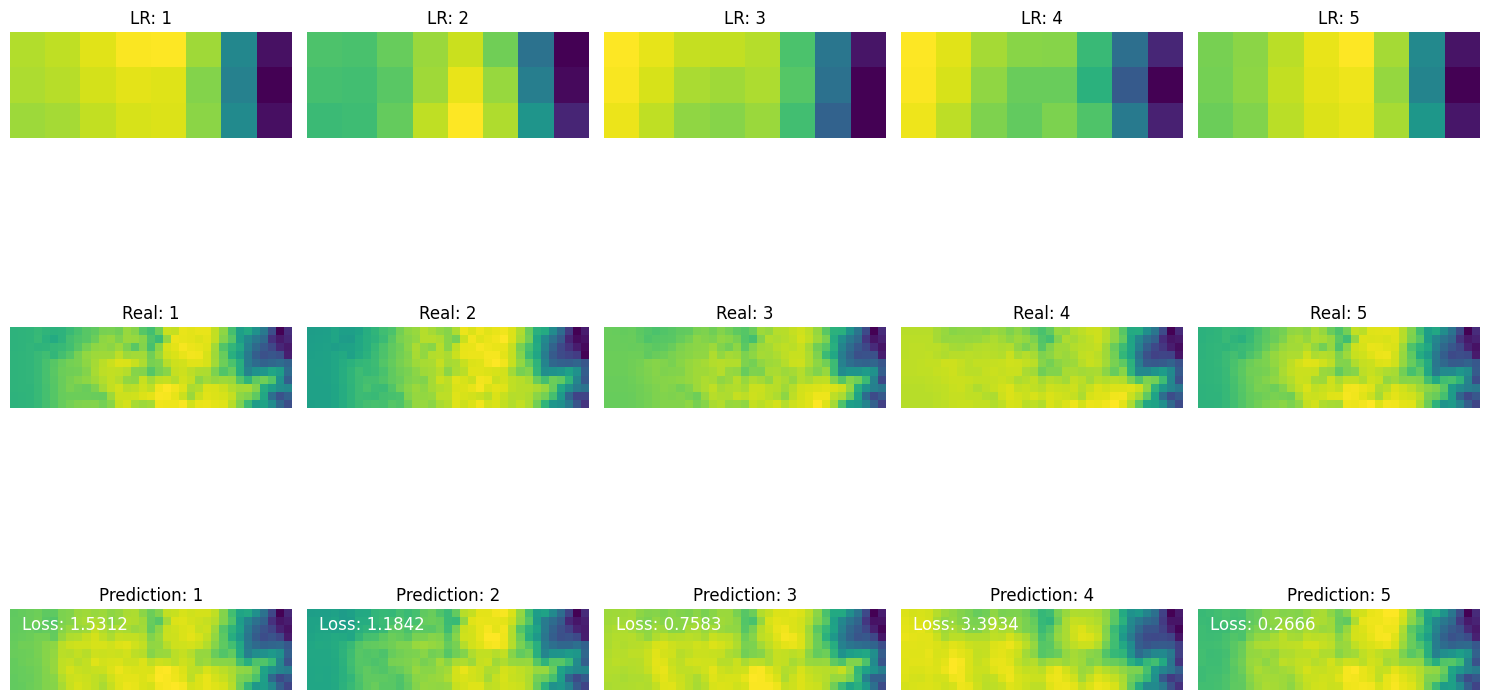

In [468]:
evaluate_model(model_4, X_test, y_test)
plot_loss(history_4)
show_examples(model_4, X_test, y_test)

In [469]:
model_4.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_squared_error')
history_5 = model_4.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),
                    callbacks=[reduce_lr, early_stopping])

Epoch 1/100


2025-03-26 11:42:11.257903: W external/local_xla/xla/service/gpu/transforms/conv_rewriter.cc:467] The low padding of the backward convolution would be negative (-5), which isn't supported by GpuConvPaddingLegalization for now (b/32744257).


 97/101 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6473

2025-03-26 11:42:12.828038: W external/local_xla/xla/service/gpu/transforms/conv_rewriter.cc:467] The low padding of the backward convolution would be negative (-5), which isn't supported by GpuConvPaddingLegalization for now (b/32744257).


101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 1.6471 - val_loss: 1.4213 - learning_rate: 1.0000e-04
Epoch 2/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.5817 - val_loss: 1.4524 - learning_rate: 1.0000e-04
Epoch 3/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6401 - val_loss: 1.4035 - learning_rate: 1.0000e-04
Epoch 4/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.5335 - val_loss: 1.5452 - learning_rate: 1.0000e-04
Epoch 5/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.5918 - val_loss: 1.4381 - learning_rate: 1.0000e-04
Epoch 6/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.5593 - val_loss: 1.3629 - learning_rate: 1.0000e-04
Epoch 7/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.5448 - val_loss: 1.5330 - learning_rate: 1.0000e-04
Epoch 8/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.5765 - val_loss: 1.3611 - learning_rate: 1.0000e-04
Epoch 9/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.5028 - val_loss: 1.3278 - le

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1480
Test loss: 1.1324923038482666


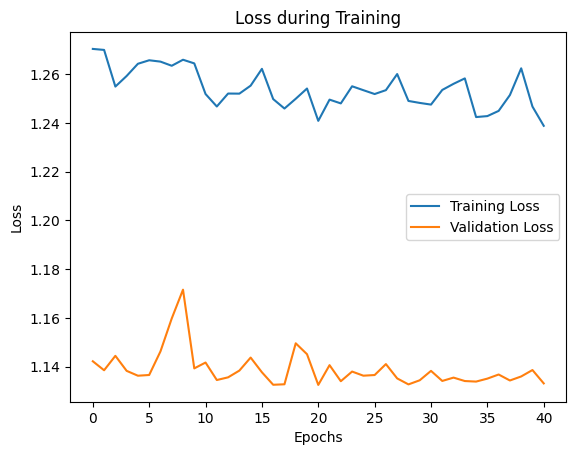

Shape de la capa sequential_136_1/batch_normalization_89_1/batchnorm/add_1:0: (32, 3, 8, 64)
Shape de la capa sequential_136_1/Conv2DTranspose_1_1/BiasAdd:0: (32, 6, 16, 128)
Shape de la capa sequential_136_1/Conv2DTranspose_2_1/BiasAdd:0: (32, 12, 48, 256)
Shape de la capa sequential_136_1/Conv2D_2_1/Relu:0: (32, 12, 48, 128)
Shape de la capa sequential_136_1/Conv2D_3_1/Relu:0: (32, 12, 48, 128)
Shape de la capa sequential_136_1/Conv2D_4_1/Add:0: (32, 12, 48, 1)
Shape de la capa sequential_136_1/Cropping_Layer_1/strided_slice:0: (32, 10, 35, 1)
 1/26 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/stepShape de la capa sequential_136_1/batch_normalization_89_1/batchnorm/add_1:0: (None, 3, 8, 64)
Shape de la capa sequential_136_1/Conv2DTranspose_1_1/BiasAdd:0: (None, 6, 16, 128)
Shape de la capa sequential_136_1/Conv2DTranspose_2_1/BiasAdd:0: (None, 12, 48, 256)
Shape de la capa sequential_136_1/Conv2D_2_1/Relu:0: (None, 12, 48, 128)
Shape de la capa sequential_136_1/Conv2D_3_1/Relu:0: (None, 12, 48, 128

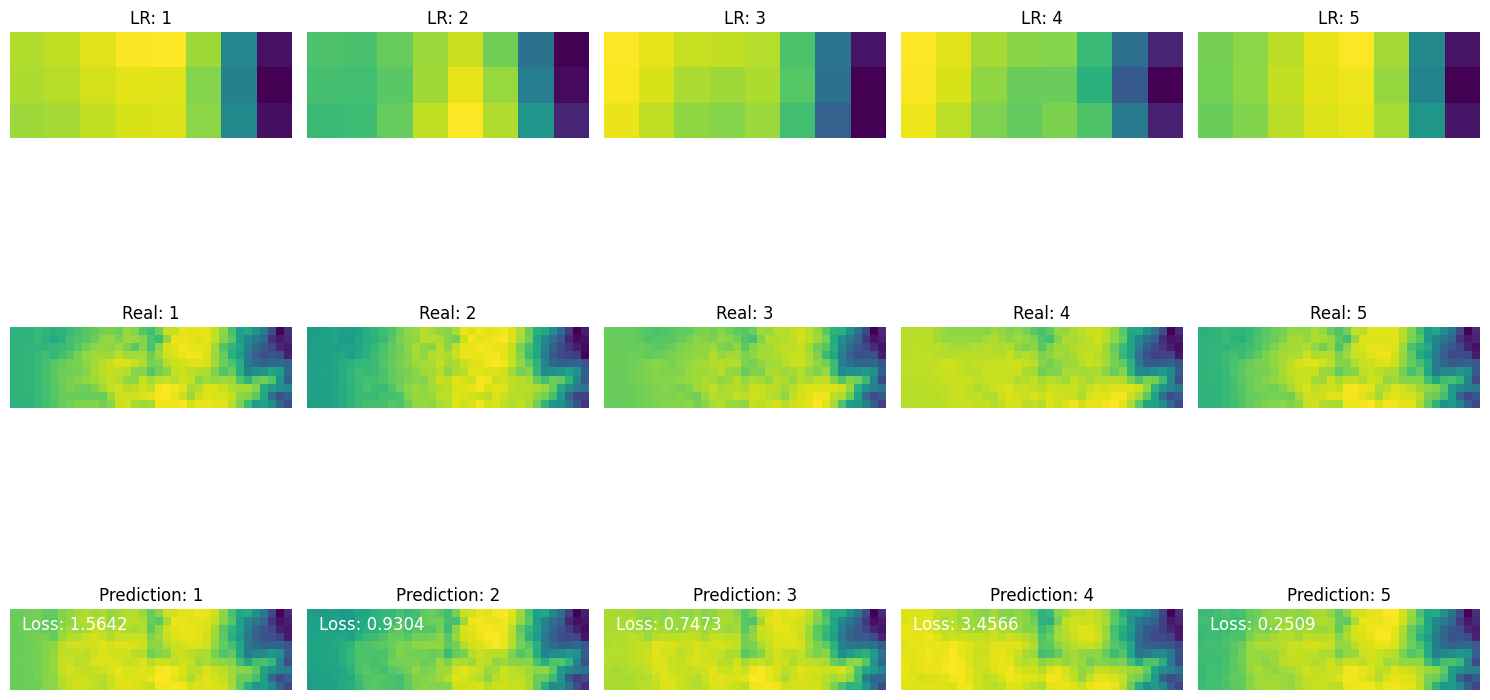

In [464]:
evaluate_model(model_4, X_test, y_test)
plot_loss(history_5)
show_examples(model_4, X_test, y_test)